In [15]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Activation
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [16]:
wandb.init()
config = wandb.config

config.max_len = 32
config.buckets = 128

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

#labels=np.array(["chirping_birds", "crickets", "crow", 
#                 "frog", "insects"])
labels=np.array(["GOC", "GRA", "GST", 
                 "GWG", "GWC", "OPI", "OQU"])

Saving vectors of label - 'GWG': 100%|██████████████████████████████████████████████| 203/203 [00:02<00:00, 101.32it/s]


In [17]:
# Loading train/test set
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test()

In [18]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 20
config.batch_size = 100

# Number of classes
num_classes = 5
print(X_train.shape)
# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)
X_val = X_val.reshape(X_val.shape[0], config.buckets, config.max_len, channels)

(703, 128, 32)


In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#111111', '#222222', '#333333', '#444444', '#555555', '#666666', '#777777', '#888888']
    markers = ['o', 's', 'o', 's','o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

def run_sampler( X, y, sampler ) :
    print(X.shape)
    print(y.shape)

    X_samples, _, _, _ = X.shape

    d2_X = X.reshape((X_samples,config.buckets*config.max_len*channels))

    X_s, y_s = sampler.fit_sample(d2_X, y)

    #plot_2d_space(X_rus, y_rus, 'Random under-sampling')

    X_s = X_s.reshape((X_s.shape[0], config.buckets, config.max_len, channels))
    print("X_s", X_s.shape)
    print("Y_s", y_s.shape)
    
    return X_s, y_s

In [ ]:
#smt = RandomUnderSampler()
#sampler = RandomOverSampler()
smt = SMOTETomek()

X_train, y_train = run_sampler( X_train, y_train, smt )
X_test, y_test = run_sampler( X_test, y_test, smt )
X_val, y_val = run_sampler( X_val, y_val, smt )

(703, 128, 32, 1)


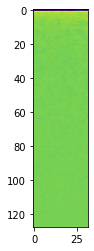

In [19]:
# Spectrogram visualized of 0th element
print(X_train.shape)
plt.imshow(X_train[10, :, :, 0])

In [20]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
y_val_hot = to_categorical(y_val)

In [21]:
# Building the model
model = Sequential()

input_shape= (config.buckets, config.max_len, channels)

model.add(Conv2D(24, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 3), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (3, 1), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(labels)))
model.add(Activation('softmax'))
model.summary()
# Conv2D: 
#    Filters: 32
#    Kernel_size: (3,3) (height/width of the 2D convolution window)     
'''model.add(Conv2D(32, (3, 3),
    input_shape=(config.buckets, config.max_len, channels),
    activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))'''

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 30, 24)       240       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 15, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 63, 15, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 13, 48)        10416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 6, 48)        

"model.add(Conv2D(32, (3, 3),\n    input_shape=(config.buckets, config.max_len, channels),\n    activation='relu'))\n\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dense(num_classes, activation='softmax'))"

In [22]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [23]:
wandb.init()
print(y_train_hot.shape)
print(labels.shape)
print(X_train.shape)
# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_val, y_val_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

(703, 5)
(5,)
(703, 128, 32, 1)
Train on 703 samples, validate on 469 samples
Epoch 1/20
703/703 [==============================] - ETA: 31s - loss: 2.6549 - accuracy: 0.156 - ETA: 15s - loss: 2.9842 - accuracy: 0.296 - ETA: 10s - loss: 3.0744 - accuracy: 0.270 - ETA: 8s - loss: 2.7303 - accuracy: 0.273 - ETA: 6s - loss: 2.4843 - accuracy: 0.30 - ETA: 5s - loss: 2.3492 - accuracy: 0.29 - ETA: 4s - loss: 2.2642 - accuracy: 0.29 - ETA: 4s - loss: 2.1689 - accuracy: 0.30 - ETA: 3s - loss: 2.1129 - accuracy: 0.29 - ETA: 3s - loss: 2.0378 - accuracy: 0.31 - ETA: 2s - loss: 1.9852 - accuracy: 0.31 - ETA: 2s - loss: 1.9340 - accuracy: 0.33 - ETA: 2s - loss: 1.9016 - accuracy: 0.33 - ETA: 1s - loss: 1.8562 - accuracy: 0.34 - ETA: 1s - loss: 1.8084 - accuracy: 0.36 - ETA: 1s - loss: 1.7684 - accuracy: 0.36 - ETA: 1s - loss: 1.7591 - accuracy: 0.37 - ETA: 0s - loss: 1.7334 - accuracy: 0.37 - ETA: 0s - loss: 1.7094 - accuracy: 0.38 - ETA: 0s - loss: 1.6844 - accuracy: 0.39 - ETA: 0s - loss: 1.659

Epoch 9/20
703/703 [==============================] - ETA: 2s - loss: 0.4845 - accuracy: 0.75 - ETA: 2s - loss: 0.4677 - accuracy: 0.78 - ETA: 2s - loss: 0.4696 - accuracy: 0.80 - ETA: 2s - loss: 0.4628 - accuracy: 0.81 - ETA: 1s - loss: 0.4336 - accuracy: 0.81 - ETA: 1s - loss: 0.4494 - accuracy: 0.82 - ETA: 1s - loss: 0.4543 - accuracy: 0.81 - ETA: 1s - loss: 0.4611 - accuracy: 0.80 - ETA: 1s - loss: 0.4484 - accuracy: 0.81 - ETA: 1s - loss: 0.4424 - accuracy: 0.82 - ETA: 1s - loss: 0.4411 - accuracy: 0.82 - ETA: 1s - loss: 0.4719 - accuracy: 0.81 - ETA: 1s - loss: 0.4809 - accuracy: 0.80 - ETA: 0s - loss: 0.4852 - accuracy: 0.80 - ETA: 0s - loss: 0.4700 - accuracy: 0.81 - ETA: 0s - loss: 0.4808 - accuracy: 0.80 - ETA: 0s - loss: 0.4666 - accuracy: 0.81 - ETA: 0s - loss: 0.4851 - accuracy: 0.80 - ETA: 0s - loss: 0.4920 - accuracy: 0.80 - ETA: 0s - loss: 0.4855 - accuracy: 0.80 - ETA: 0s - loss: 0.4795 - accuracy: 0.81 - 3s 4ms/step - loss: 0.4820 - accuracy: 0.8094 - val_loss: 0.4047

Epoch 17/20
703/703 [==============================] - ETA: 2s - loss: 0.0761 - accuracy: 1.00 - ETA: 2s - loss: 0.0978 - accuracy: 0.98 - ETA: 2s - loss: 0.1218 - accuracy: 0.95 - ETA: 2s - loss: 0.1368 - accuracy: 0.94 - ETA: 2s - loss: 0.1530 - accuracy: 0.93 - ETA: 2s - loss: 0.1898 - accuracy: 0.92 - ETA: 2s - loss: 0.1810 - accuracy: 0.93 - ETA: 2s - loss: 0.1851 - accuracy: 0.93 - ETA: 1s - loss: 0.2138 - accuracy: 0.93 - ETA: 1s - loss: 0.2094 - accuracy: 0.93 - ETA: 1s - loss: 0.2079 - accuracy: 0.93 - ETA: 1s - loss: 0.1979 - accuracy: 0.93 - ETA: 1s - loss: 0.2033 - accuracy: 0.93 - ETA: 1s - loss: 0.2072 - accuracy: 0.92 - ETA: 0s - loss: 0.2051 - accuracy: 0.92 - ETA: 0s - loss: 0.2008 - accuracy: 0.93 - ETA: 0s - loss: 0.1977 - accuracy: 0.93 - ETA: 0s - loss: 0.2074 - accuracy: 0.92 - ETA: 0s - loss: 0.2194 - accuracy: 0.92 - ETA: 0s - loss: 0.2159 - accuracy: 0.92 - ETA: 0s - loss: 0.2109 - accuracy: 0.93 - 3s 5ms/step - loss: 0.2068 - accuracy: 0.9317 - val_loss: 0.256

In [24]:
# Save the keras model
model.save("geo_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [25]:
from keras.models import load_model

# Load the model
loaded_model = load_model('geo_cnn_model.h5')

In [26]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 30, 24)       240       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 15, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 63, 15, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 13, 48)        10416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 6, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 30, 6, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 6, 48)        

In [27]:
y_pred_ohe = loaded_model.predict(X_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape
print(confusion_matrix)

for class_i in range(len(labels)) :
    indices = np.argwhere(y_test == class_i)
    sum = 0
    for index in indices:
        sum += (y_test[index] == y_pred_labels[index])
    if(len(indices) > 0) : mean = sum/len(indices)
    else : mean = "N/A"
    print("Accuracy for class", labels[class_i], ":", mean)

print("Overall Accuracy :", np.mean(y_test == y_pred_labels))

'''[[ 19   0   0   0   0]
 [  1 112   0  10   0]
 [  0   0  14   0   0]
 [  1  12   1  67  14]
 [  0   1   0   3  39]]
Accuracy for class GOC : [1.]
Accuracy for class GRA : [0.91056911]
Accuracy for class GST : [1.]
Accuracy for class GWG : [0.70526316]
Accuracy for class GWC : [0.90697674]
Overall Accuracy : 0.8537414965986394'''

[[ 19   0   0   0   0]
 [  1 112   0  10   0]
 [  0   0  14   0   0]
 [  1  12   1  67  14]
 [  0   1   0   3  39]]
Accuracy for class GOC : [1.]
Accuracy for class GRA : [0.91056911]
Accuracy for class GST : [1.]
Accuracy for class GWG : [0.70526316]
Accuracy for class GWC : [0.90697674]
Overall Accuracy : 0.8537414965986394


'[[ 19   0   0   0   0]\n [  0 119   0   4   0]\n [  0   0  14   0   0]\n [  2  19   0  67   7]\n [  0   4   0   3  36]]\nAccuracy for class GOC : [1.]\nAccuracy for class GRA : [0.96747967]\nAccuracy for class GST : [1.]\nAccuracy for class GWG : [0.70526316]\nAccuracy for class GWC : [0.8372093]\nOverall Accuracy : 0.8673469387755102'

In [28]:
## Running the model

n_mfcc = config.buckets
max_len = config.max_len
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
file_path = "./prediction/nature_sc.wav"
big_wave, sr = librosa.load(file_path, mono=True, sr=None)
#print(wave.shape, sr)

classification = []

for sec_index in range( int(big_wave.shape[0] / sr) ) :
    start_sec = sec_index
    end_sec = sec_index + 1
    
    sec_to_trim = np.array( [ float(start_sec), float(end_sec) ] )
    print(sec_to_trim)
    sec_to_trim = np.ceil( sec_to_trim * sr )

    wave = big_wave[int(sec_to_trim[0]) : int(sec_to_trim[1])]
    print(wave)

    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    # Convert wav to MFCC
    prediction_data = wav2mfcc('./prediction/nature_sc.wav')
    prediction_data = mfcc
    print(prediction_data.shape)
    #print(wav2mfcc())
    # Reshape to 4 dimensions
    prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)
    #prediction_data = prediction_data.reshape(1, 20, config.max_len, channels)

    # Run the model on the inputted file
    predicted = loaded_model.predict(prediction_data)

    # Output the prediction values for each class
    print ('PREDICTED VALUES')
    labels_indices = range(len(labels))
    max_value = 0
    max_value_index = 0
    for index in labels_indices:
        print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
        if predicted[0,index] > max_value:
            max_value_index = index
            max_value = predicted[0,index]

    # Output the prediction
    if max_value < 0.5:
        print("GUESS: Nothing")
        classification.append( { "class" : "Nothing", "timestamp" : start_sec } )
    else:
        print('\n\nGUESS: ', labels[max_value_index])
        classification.append( { "class" : labels[max_value_index], "timestamp" : start_sec } )

print(classification)

[0. 1.]
[ 0.0000000e+00  1.5258789e-05  0.0000000e+00 ...  3.3020020e-02
  1.2680054e-02 -8.7432861e-03]
(128, 32)
PREDICTED VALUES

 GOC :  0.00000176

 GRA :  0.38465884

 GST :  0.00000003

 GWG :  0.00648697

 GWC :  0.60885239


GUESS:  GWC
[1. 2.]
[-0.03717041 -0.05769348 -0.06455994 ...  0.01766968  0.01895142
  0.01779175]
(128, 32)
PREDICTED VALUES

 GOC :  0.00000044

 GRA :  0.00247770

 GST :  0.00000003

 GWG :  0.01955874

 GWC :  0.97796303


GUESS:  GWC
[2. 3.]
[ 0.02345276  0.02101135  0.01712036 ... -0.01161194 -0.0141449
 -0.01431274]
(128, 32)
PREDICTED VALUES

 GOC :  0.00002324

 GRA :  0.00770301

 GST :  0.00000020

 GWG :  0.01101210

 GWC :  0.98126149


GUESS:  GWC
[3. 4.]
[-0.01583862 -0.01066589 -0.00762939 ... -0.0377655  -0.03556824
 -0.02685547]
(128, 32)
PREDICTED VALUES

 GOC :  0.00001256

 GRA :  0.94493687

 GST :  0.00001222

 GWG :  0.03799357

 GWC :  0.01704480


GUESS:  GRA
[4. 5.]
[-0.02836609 -0.02510071 -0.02012634 ...  0.0138855  -0.0038604